In [21]:

import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sb
from pckgs.headline_preprocess import HeadlinePreprocess
from pckgs.models import get_model_both_emb
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
price = pd.read_csv('../Price/datasets/bitcoin_position_day_20.csv', parse_dates=['Timestamp'])
price.rename(columns={'Timestamp':'date'}, inplace=True)
price.set_index('date', inplace=True)
y = price.loc[:,['down', 'same', 'up']]
x1 = price.drop(['down', 'same', 'up'], axis=1)
x1

,pChange_scaled_t-1,pChange_scaled_t-2,pChange_scaled_t-3,pChange_scaled_t-4,pChange_scaled_t-5,pChange_scaled_t-6,pChange_scaled_t-7,pChange_scaled_t-8,pChange_scaled_t-9,pChange_scaled_t-10,pChange_scaled_t-11,pChange_scaled_t-12,pChange_scaled_t-13,pChange_scaled_t-14,pChange_scaled_t-15,pChange_scaled_t-16,pChange_scaled_t-17,pChange_scaled_t-18,pChange_scaled_t-19,pChange_scaled_t-20
date,,,,,,,,,,,,,,,,,,,,
2015-01-22,0.257598,-0.149628,0.035143,0.189588,-0.203272,-0.101704,0.850764,-1.000000,-0.635317,-0.032267,-0.177178,-0.290542,0.194007,-0.047309,-0.047309,-0.047309,0.141311,-0.295625,-0.459500,-0.027349
2015-01-23,0.071202,0.257598,-0.149628,0.035143,0.189588,-0.203272,-0.101704,0.850764,-1.000000,-0.635317,-0.032267,-0.177178,-0.290542,0.194007,-0.047309,-0.047309,-0.047309,0.141311,-0.295625,-0.459500
2015-01-24,-0.054621,0.071202,0.257598,-0.149628,0.035143,0.189588,-0.203272,-0.101704,0.850764,-1.000000,-0.635317,-0.032267,-0.177178,-0.290542,0.194007,-0.047309,-0.047309,-0.047309,0.141311,-0.295625
2015-01-25,0.211611,-0.054621,0.071202,0.257598,-0.149628,0.035143,0.189588,-0.203272,-0.101704,0.850764,-1.000000,-0.635317,-0.032267,-0.177178,-0.290542,0.194007,-0.047309,-0.047309,-0.047309,0.141311
2015-01-26,0.048235,0.211611,-0.054621,0.071202,0.257598,-0.149628,0.035143,0.189588,-0.203272,-0.101704,0.850764,-1.000000,-0.635317,-0.032267,-0.177178,-0.290542,0.194007,-0.047309,-0.047309,-0.047309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,-0.051358,-0.077206,-0.081685,-0.147564,0.149889,-0.072567,-0.023073,-0.120631,0.349592,-0.199869,-0.174645,-0.016419,-0.153680,-0.009940,-0.057564,-0.051972,-0.113264,-0.142308,-0.036103,-0.067498
2019-12-28,-0.016081,-0.051358,-0.077206,-0.081685,-0.147564,0.149889,-0.072567,-0.023073,-0.120631,0.349592,-0.199869,-0.174645,-0.016419,-0.153680,-0.009940,-0.057564,-0.051972,-0.113264,-0.142308,-0.036103
2019-12-29,-0.020335,-0.016081,-0.051358,-0.077206,-0.081685,-0.147564,0.149889,-0.072567,-0.023073,-0.120631,0.349592,-0.199869,-0.174645,-0.016419,-0.153680,-0.009940,-0.057564,-0.051972,-0.113264,-0.142308


In [23]:
#read headline vectors and shape them correctly
headline = pd.read_csv('../Text/datasets/headline_embeddings_mean.csv', index_col='date', parse_dates=['date'])
# df = pd.read_csv('./datasets/headline_embeddings_mean_pca.csv', index_col='date', parse_dates=['date'])
# create shifted observations and reshape to 3d input
lag = 21  # 20+1 so we don't use headlines from same day (leakage)
x2 = HeadlinePreprocess.shape_vectors(headline, lag, y.index)



               0_t-1     1_t-1     2_t-1     3_t-1     4_t-1     5_t-1  \
date                                                                     
2015-01-22  0.092871  0.228522 -0.193380 -0.175753 -0.223146  0.351874   
2015-01-23  0.211204 -0.254842 -0.315833 -0.111376 -0.450111  0.195621   
2015-01-24  0.185123 -0.460156  0.153764 -0.578861 -0.472663  0.460326   
2015-01-25  0.024464 -0.348920  0.059330  0.009928  0.183207  0.423806   
2015-01-26  0.377936 -0.037442  0.140681  0.024155  0.191069 -0.034123   

               6_t-1     7_t-1     8_t-1     9_t-1  ...  758_t-20  759_t-20  \
date                                                ...                       
2015-01-22  0.193213 -0.289677  0.042950  0.261798  ...  0.164454 -0.115448   
2015-01-23 -0.029607 -0.110427  0.100831  0.529869  ...  0.455318 -0.213426   
2015-01-24 -0.052701 -0.063623  0.280509 -0.120617  ... -0.046153 -0.023415   
2015-01-25  0.306283 -0.777522  0.541920 -0.197269  ...  0.330218 -0.057513   
2015-01

In [25]:
#price
x1_train, x1_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, shuffle=False)
#vecs
x2_train, x2_test, _, _ = train_test_split(x2, y, test_size=0.2, shuffle=False)
del _
print(x1_train.shape)
print(x2_train.shape)

y_index = y_test.index
x_index = y_train.index

(1444, 20)
(1444, 20, 768)


In [26]:
y_test_labeled = y_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_test_labeled = y_test_labeled.idxmax(axis=1)

y_train_labeled = y_train.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_train_labeled = y_train_labeled.idxmax(axis=1)

In [27]:
df_candle = pd.read_csv('../Price/datasets/bitcoin_candle_day.csv', header=0, parse_dates=['Timestamp'])
df_candle.rename(columns={'Timestamp':'date'}, inplace=True)
df_candle.set_index('date', inplace=True)
df_candle.rename(columns={'Open': 'open', 'Low': 'low', 'High': 'high', 'Close': 'close'}, inplace=True)
# align dates
df_candle = df_candle.reindex(y_test.index)

In [42]:
model = get_model_both_emb()

In [43]:
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=0, patience=60)
mc = ModelCheckpoint('merged.h5',verbose=0, save_best_only=True)

history = model.fit(x=[x1_train, x2_train], y=y_train, validation_data=([x1_test, x2_test], y_test),
                           batch_size=32, epochs=100, callbacks=[es, mc], verbose=0)#, shuffle=False)

model= load_model('merged.h5')

<AxesSubplot:>

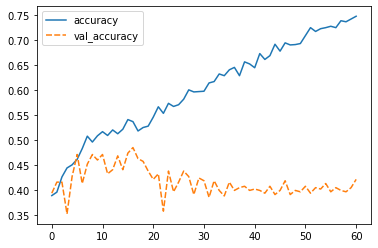

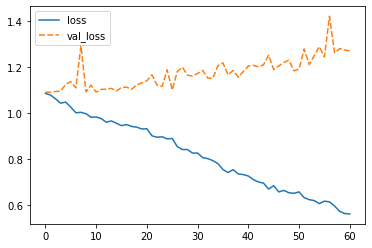

In [45]:
ac = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
plt.figure()
sb.lineplot(data=ac)

loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
plt.figure()
sb.lineplot(data=loss)

In [46]:
y_pred = model.predict([x1_test, x2_test])
y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=y_index)
y_pred_labeled = y_pred_labeled.idxmax(axis=1)

In [47]:
y_predt = model.predict([x1_train, x2_train])
y_predt_labeled = pd.DataFrame(y_predt, columns=[-1, 0, 1], index=x_index)
y_predt_labeled = y_predt_labeled.idxmax(axis=1)

In [48]:
print(classification_report(y_test_labeled, y_pred_labeled))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       103
           0       0.42      0.87      0.57       142
           1       0.39      0.22      0.29       116

    accuracy                           0.42       361
   macro avg       0.27      0.37      0.28       361
weighted avg       0.29      0.42      0.32       361



/home/solon/anaconda3/envs/Ptyxiaki/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
#test
temp =  {'train_accuracy':[], 'train_f1':[], 'test_accuracy':[], 'test_f1':[]}

for i in range(10):
    model = get_model_both_emb()
    es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=0, patience=60)
    mc = ModelCheckpoint('model_price.h5',verbose=0, save_best_only=True)    #MLP

    history = model.fit(x=[x1_train, x2_train], y=y_train, validation_data=([x1_test, x2_test], y_test), batch_size=32
                        ,epochs=300, verbose=0, callbacks=[es, mc])#, shuffle=False)
    model = load_model('model_price.h5')
    y_pred = model.predict([x1_test, x2_test])
    y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=y_index)
    y_pred_labeled = y_pred_labeled.idxmax(axis=1)
    y_predt = model.predict([x1_train, x2_train])
    y_predt_labeled = pd.DataFrame(y_predt, columns=[-1, 0, 1], index=x_index)
    y_predt_labeled = y_predt_labeled.idxmax(axis=1)
    results_test = classification_report(y_test_labeled, y_pred_labeled, output_dict=True)
    temp['test_accuracy'].append(results_test['accuracy'])
    temp['test_f1'].append(results_test['weighted avg']['f1-score'])
    results_test = classification_report(y_train_labeled, y_predt_labeled, output_dict=True)
    temp['train_accuracy'].append(results_test['accuracy'])
    temp['train_f1'].append(results_test['weighted avg']['f1-score'])
temp

/home/solon/anaconda3/envs/Ptyxiaki/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/solon/anaconda3/envs/Ptyxiaki/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/solon/anaconda3/envs/Ptyxiaki/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

{'train_accuracy': [0.5304709141274239,
  0.5,
  0.5117728531855956,
  0.5214681440443213,
  0.5367036011080333,
  0.49238227146814406,
  0.554016620498615,
  0.4840720221606648,
  0.4909972299168975,
  0.5228531855955678],
 'train_f1': [0.46186854469026883,
  0.4264973675970342,
  0.4391820813118993,
  0.45043507485592504,
  0.5117413191147762,
  0.4224071664347011,
  0.4853633108482287,
  0.4089143745319181,
  0.4241081514391978,
  0.4716540895048077],
 'test_accuracy': [0.45429362880886426,
  0.4626038781163435,
  0.4792243767313019,
  0.4182825484764543,
  0.4515235457063712,
  0.41274238227146814,
  0.45706371191135736,
  0.47368421052631576,
  0.481994459833795,
  0.4404432132963989],
 'test_f1': [0.37912185615610533,
  0.38192230254712517,
  0.4005674357081924,
  0.3395393754543133,
  0.4098899256451377,
  0.3371622644286785,
  0.3805414752391764,
  0.39313355158230506,
  0.4009834992456114,
  0.408017343498055]}

In [54]:
import statistics

print(statistics.mean(temp['train_f1']))
print(statistics.mean(temp['test_f1']))
print(statistics.mean(temp['train_accuracy']))
print(statistics.mean(temp['test_accuracy']))

0.4502171480328757
0.38308790295047
0.5144736842105263
0.45318559556786703
